In [3]:
! pip install medmnist

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from medmnist import PathMNIST

In [6]:
train = PathMNIST(split='train', download=True)
val = PathMNIST(split='val', download=True)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [7]:
X, y = train.imgs / 255.0, train.labels
X_val, y_val = val.imgs / 255.0, val.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = np.expand_dims(X_train, -1)
# X_val = np.expand_dims(X_val, -1)
# X_test = np.expand_dims(X_test, -1)

In [8]:
print("Number of images in training set:", len(X_train))
print("Number of images in validation set:", len(X_val))
print("Number of images in test set:", len(X_test))
print("Total : ",len(X_train)+len(X_val)+len(X_test))

Number of images in training set: 71996
Number of images in validation set: 10004
Number of images in test set: 18000
Total :  100000


In [10]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

# Convert images to grayscale by averaging the RGB channels
X_train = np.mean(X_train, axis=-1, keepdims=True)
X_val = np.mean(X_val, axis=-1, keepdims=True)
X_test = np.mean(X_test, axis=-1, keepdims=True)

In [11]:
class SynapticIntelligence:
    def __init__(self, model):
        self.model = model
        self.omega = [tf.zeros_like(weight) for weight in model.trainable_weights]
        self.init_weights = [tf.identity(weight) for weight in model.trainable_weights]
        self.importance_accumulation = [tf.zeros_like(weight) for weight in model.trainable_weights]
    
    def update_importance(self, gradients):
        for i, grad in enumerate(gradients):
            self.importance_accumulation[i] += tf.square(grad)
    
    def consolidate(self):
        for i, weight in enumerate(self.model.trainable_weights):
            self.omega[i] += self.importance_accumulation[i] / (tf.square(weight - self.init_weights[i]) + 1e-7)
            self.importance_accumulation[i] = tf.zeros_like(weight)
            self.init_weights[i] = tf.identity(weight)
    
    def regularization_loss(self):
        loss = 0
        for omega, init_weight, current_weight in zip(self.omega, self.init_weights, self.model.trainable_weights):
            loss += tf.reduce_sum(omega * tf.square(current_weight - init_weight))
        return loss


In [12]:
def create_model(num_classes, input_shape=(28,28, 1)):
    model = Sequential([
        Conv2D(25, (4,4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(111, (4,4), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(123, (4,4), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(102, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0007008969316805274),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
from tqdm import tqdm

def train_task_with_si(model, si, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, si_lambda=0.1):
    optimizer = Adam(learning_rate=0.0001)
    
    # Initialize history lists
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        with tqdm(total=len(X_train) // batch_size, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for batch in range(0, len(X_train), batch_size):
                X_batch = X_train[batch:batch+batch_size]
                y_batch = y_train[batch:batch+batch_size]
                with tf.GradientTape() as tape:
                    preds = model(X_batch, training=True)
                    task_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_batch, preds))
                    reg_loss = si_lambda * si.regularization_loss()
                    total_loss = task_loss + reg_loss
                gradients = tape.gradient(total_loss, model.trainable_weights)
                si.update_importance(gradients)
                optimizer.apply_gradients(zip(gradients, model.trainable_weights))
                
                pbar.update(1)
        
        # Evaluate on the validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        
        # Store the metrics in history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    si.consolidate()
    return history


In [14]:

def filter_data(X, y, classes):
    mask = np.isin(y, classes).flatten()
    return X[mask], y[mask]

In [15]:

def evaluate(model, X_test, y_test, task_num):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"\nTask {task_num} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


<h1>Task 1</h1>

In [17]:
# Initial model training on classes 0 and 1
num_classes = 2
model = create_model(num_classes)
si = SynapticIntelligence(model)

In [18]:
# Prepare data for classes 0 and 1
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1])

In [19]:
# Check shapes of augmented data
print(f"Shape of augmented X_train: {X_train_task.shape}") 
print(f"Shape of augmented y_train: {y_train_task.shape}") 

Shape of augmented X_train: (15029, 28, 28, 1)
Shape of augmented y_train: (15029, 1)


In [20]:
print("Training on initial Task (Classes 0 and 1)")
history_01 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1]), task_num=1)

Training on initial Task (Classes 0 and 1)
Epoch 1/5


Training Epoch 1/5: 470batch [00:58,  8.06batch/s]                      


Training Loss: 0.4692, Training Accuracy: 0.7508
Validation Loss: 0.4779, Validation Accuracy: 0.7431
Epoch 2/5


Training Epoch 2/5: 470batch [00:55,  8.50batch/s]                      


Training Loss: 0.1052, Training Accuracy: 0.9584
Validation Loss: 0.1235, Validation Accuracy: 0.9542
Epoch 3/5


Training Epoch 3/5: 470batch [00:55,  8.48batch/s]                      


Training Loss: 0.1875, Training Accuracy: 0.9263
Validation Loss: 0.2102, Validation Accuracy: 0.9113
Epoch 4/5


Training Epoch 4/5: 470batch [00:55,  8.44batch/s]                      


Training Loss: 0.0906, Training Accuracy: 0.9623
Validation Loss: 0.1297, Validation Accuracy: 0.9519
Epoch 5/5


Training Epoch 5/5: 470batch [00:55,  8.46batch/s]                      


Training Loss: 0.5242, Training Accuracy: 0.8822
Validation Loss: 0.5953, Validation Accuracy: 0.8713
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      1.00      0.88      1840
     Class 1       1.00      0.75      0.85      2006

    accuracy                           0.87      3846
   macro avg       0.89      0.87      0.87      3846
weighted avg       0.90      0.87      0.87      3846



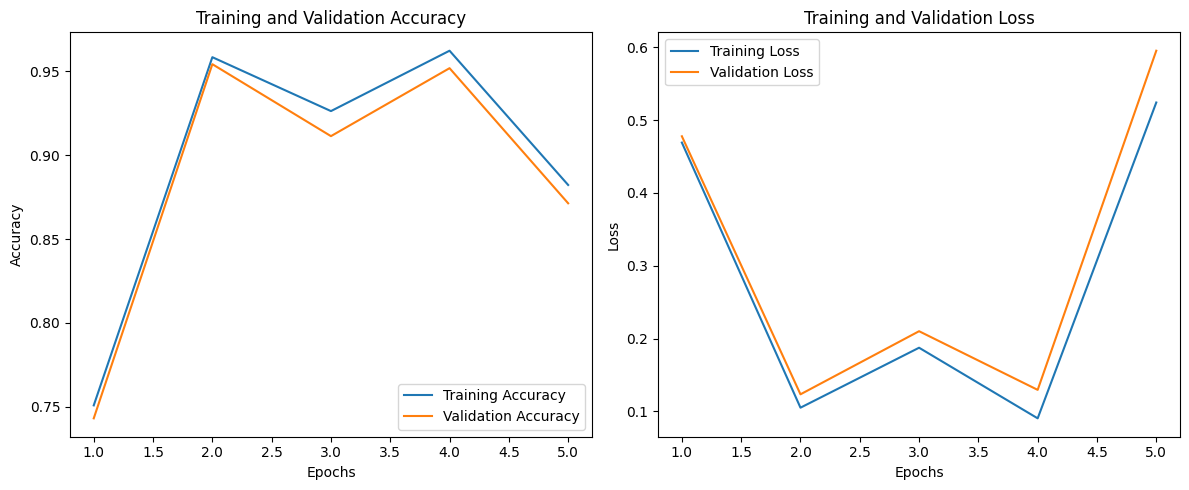

In [21]:
plot_training_history(history_01)

In [22]:
# Consolidate knowledge on classes 0 and 1
si.consolidate()

<h1> Task 2</h1>

In [23]:
# Extend model to handle classes 0, 1, and 2
num_classes = 3
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)

In [24]:
# Prepare data for classes 0, 1, and 2
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2])


In [25]:
print("\nTraining on Task with Classes 0, 1, and 2")
history_012 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2]), task_num=1)


Training on Task with Classes 0, 1, and 2
Epoch 1/5


Training Epoch 1/5: 732batch [01:26,  8.46batch/s]                      


Training Loss: 0.3253, Training Accuracy: 0.8904
Validation Loss: 0.3388, Validation Accuracy: 0.8855
Epoch 2/5


Training Epoch 2/5: 732batch [01:27,  8.36batch/s]                      


Training Loss: 0.2348, Training Accuracy: 0.9161
Validation Loss: 0.2508, Validation Accuracy: 0.9102
Epoch 3/5


Training Epoch 3/5: 732batch [01:28,  8.29batch/s]                      


Training Loss: 0.1530, Training Accuracy: 0.9362
Validation Loss: 0.1822, Validation Accuracy: 0.9262
Epoch 4/5


Training Epoch 4/5: 732batch [01:28,  8.27batch/s]                      


Training Loss: 0.2027, Training Accuracy: 0.9185
Validation Loss: 0.2419, Validation Accuracy: 0.9080
Epoch 5/5


Training Epoch 5/5: 732batch [01:27,  8.35batch/s]                      


Training Loss: 0.3048, Training Accuracy: 0.8768
Validation Loss: 0.3671, Validation Accuracy: 0.8569
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.76      0.86      1840
     Class 1       0.81      0.84      0.82      2006
     Class 2       0.83      0.98      0.90      1994

    accuracy                           0.86      5840
   macro avg       0.88      0.86      0.86      5840
weighted avg       0.87      0.86      0.86      5840



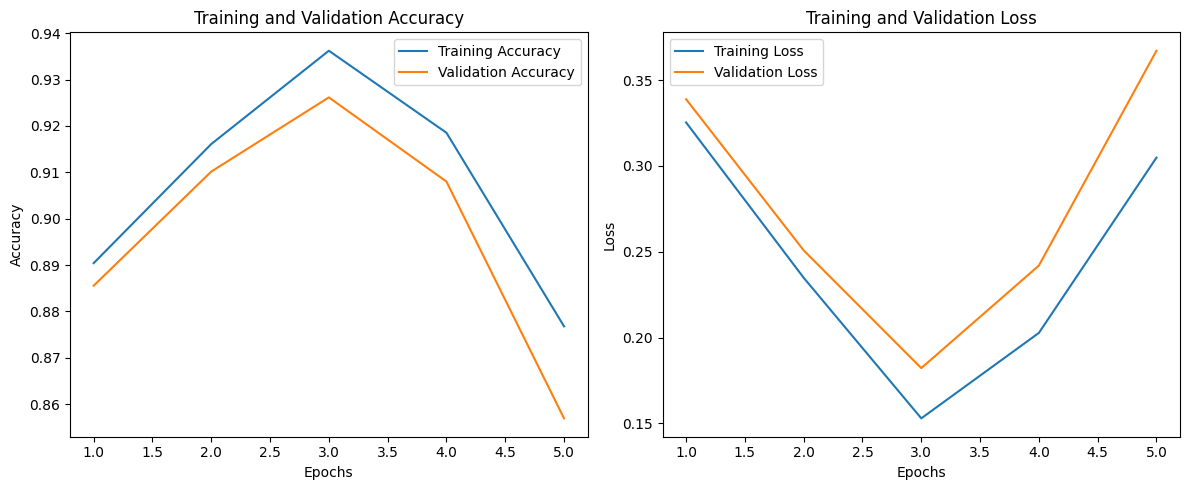

In [26]:
plot_training_history(history_012)

In [27]:
# Consolidate knowledge on classes 0, 1, and 2
si.consolidate()

<h1> Task 3</h1>

In [28]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 4
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [29]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3])

In [31]:
print("\nTraining on Task with Classes 0, 1, 2, and 3")
history_0123 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2, 3]), task_num=1)




Training on Task with Classes 0, 1, 2, and 3
Epoch 1/5


Training Epoch 1/5: 992batch [01:56,  8.49batch/s]                      


Training Loss: 0.2321, Training Accuracy: 0.9100
Validation Loss: 0.2724, Validation Accuracy: 0.8947
Epoch 2/5


Training Epoch 2/5: 992batch [01:57,  8.47batch/s]                      


Training Loss: 0.1532, Training Accuracy: 0.9416
Validation Loss: 0.2133, Validation Accuracy: 0.9206
Epoch 3/5


Training Epoch 3/5: 992batch [01:57,  8.43batch/s]                      


Training Loss: 0.4903, Training Accuracy: 0.8161
Validation Loss: 0.5515, Validation Accuracy: 0.8003
Epoch 4/5


Training Epoch 4/5: 992batch [01:57,  8.46batch/s]                      


Training Loss: 0.2389, Training Accuracy: 0.9034
Validation Loss: 0.3328, Validation Accuracy: 0.8681
Epoch 5/5


Training Epoch 5/5: 992batch [01:57,  8.47batch/s]                      


Training Loss: 0.3690, Training Accuracy: 0.8460
Validation Loss: 0.4846, Validation Accuracy: 0.8089
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.71      0.82      1840
     Class 1       0.72      0.97      0.82      2006
     Class 2       0.74      0.83      0.78      1994
     Class 3       0.97      0.75      0.85      2071

    accuracy                           0.82      7911
   macro avg       0.85      0.81      0.82      7911
weighted avg       0.85      0.82      0.82      7911



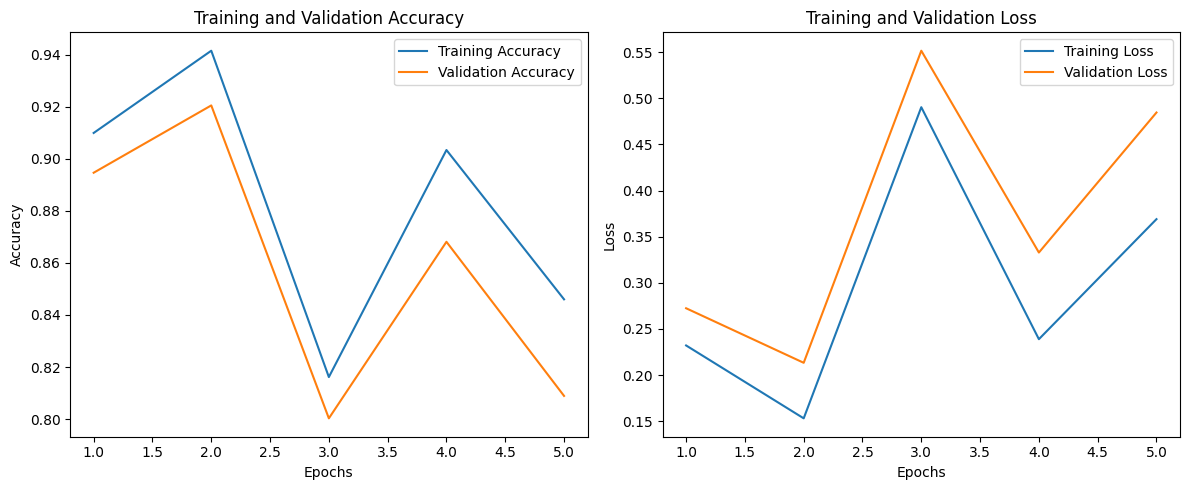

In [32]:
plot_training_history(history_0123)

In [33]:
si.consolidate()

<h1>Task 4</h1>

In [34]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 5
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [35]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3, 4])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3, 4])

In [36]:
print("\nTraining on Task with Classes 0, 1, 2, 3 and 4")
history_01234 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2, 3, 4]), task_num=1)




Training on Task with Classes 0, 1, 2, 3 and 4
Epoch 1/5


Training Epoch 1/5: 1193batch [02:19,  8.54batch/s]                       


Training Loss: 0.4831, Training Accuracy: 0.8181
Validation Loss: 0.5027, Validation Accuracy: 0.8085
Epoch 2/5


Training Epoch 2/5: 1193batch [02:20,  8.49batch/s]                       


Training Loss: 0.4651, Training Accuracy: 0.8160
Validation Loss: 0.5108, Validation Accuracy: 0.8032
Epoch 3/5


Training Epoch 3/5: 1193batch [02:19,  8.55batch/s]                       


Training Loss: 0.4759, Training Accuracy: 0.8128
Validation Loss: 0.5491, Validation Accuracy: 0.7902
Epoch 4/5


Training Epoch 4/5: 1193batch [02:19,  8.54batch/s]                       


Training Loss: 0.4958, Training Accuracy: 0.8181
Validation Loss: 0.5785, Validation Accuracy: 0.7917
Epoch 5/5


Training Epoch 5/5: 1193batch [02:19,  8.57batch/s]                       


Training Loss: 0.3543, Training Accuracy: 0.8660
Validation Loss: 0.4518, Validation Accuracy: 0.8353
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.62      0.76      1840
     Class 1       0.90      0.92      0.91      2006
     Class 2       0.88      0.78      0.83      1994
     Class 3       0.94      0.95      0.94      2071
     Class 4       0.61      0.92      0.73      1583

    accuracy                           0.84      9494
   macro avg       0.86      0.84      0.83      9494
weighted avg       0.87      0.84      0.84      9494



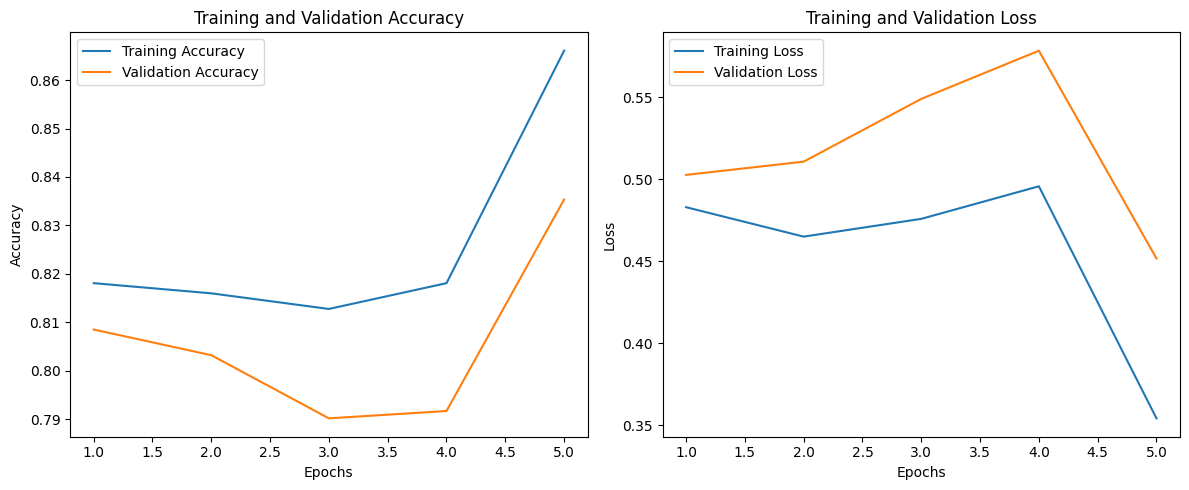

In [37]:
plot_training_history(history_01234)

In [38]:
si.consolidate()

<h1> Task 5</h1>

In [39]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 6
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [40]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3, 4, 5])

In [41]:
print("\nTraining on Task with Classes 0, 1, 2, 3, 4 and 5")
history_012345 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2, 3, 4, 5]), task_num=1)




Training on Task with Classes 0, 1, 2, 3, 4 and 5
Epoch 1/5


Training Epoch 1/5: 1497batch [02:52,  8.69batch/s]                       


Training Loss: 0.7502, Training Accuracy: 0.7056
Validation Loss: 0.7716, Validation Accuracy: 0.6937
Epoch 2/5


Training Epoch 2/5: 1497batch [02:53,  8.61batch/s]                       


Training Loss: 1.0000, Training Accuracy: 0.6461
Validation Loss: 1.0195, Validation Accuracy: 0.6389
Epoch 3/5


Training Epoch 3/5: 1497batch [02:52,  8.68batch/s]                       


Training Loss: 0.4759, Training Accuracy: 0.8206
Validation Loss: 0.5292, Validation Accuracy: 0.7979
Epoch 4/5


Training Epoch 4/5: 1497batch [02:53,  8.64batch/s]                       


Training Loss: 0.4069, Training Accuracy: 0.8437
Validation Loss: 0.4778, Validation Accuracy: 0.8128
Epoch 5/5


Training Epoch 5/5: 1497batch [02:53,  8.64batch/s]                       


Training Loss: 0.4021, Training Accuracy: 0.8418
Validation Loss: 0.5018, Validation Accuracy: 0.8063
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93      1840
     Class 1       0.96      0.89      0.93      2006
     Class 2       0.80      0.54      0.64      1994
     Class 3       0.93      0.96      0.94      2071
     Class 4       0.71      0.74      0.73      1583
     Class 5       0.66      0.85      0.75      2441

    accuracy                           0.82     11935
   macro avg       0.83      0.82      0.82     11935
weighted avg       0.83      0.82      0.82     11935



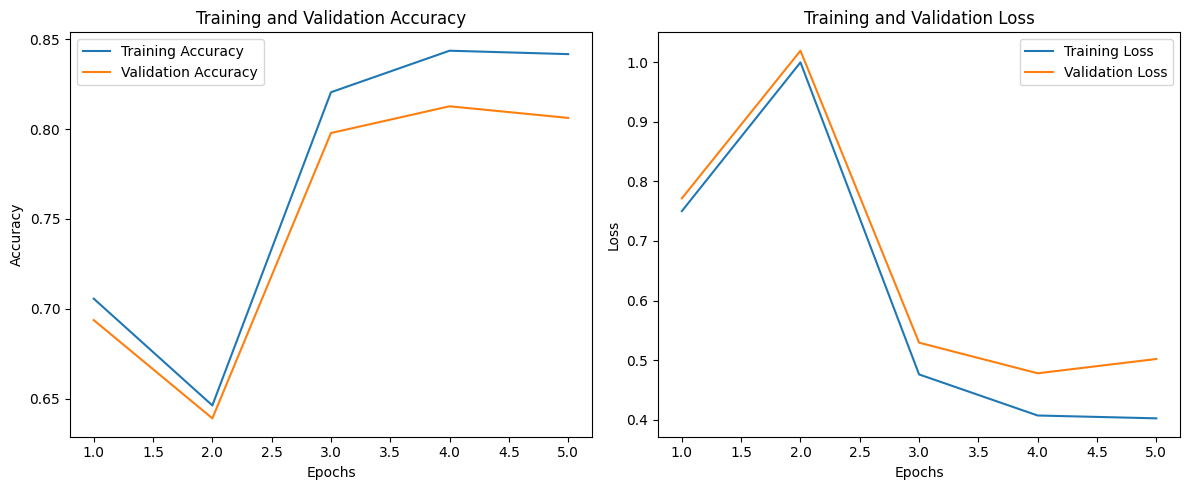

In [42]:
plot_training_history(history_012345)

In [43]:
si.consolidate()

<h1>Task 6</h1>

In [44]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 7
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [45]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5, 6])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3, 4, 5, 6])

In [47]:
print("\nTraining on Task with Classes 0, 1, 2, 3, 4 , 5 and 6")
history_0123456 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_test, y_test, [0, 1, 2, 3, 4, 5, 6]), task_num=1)




Training on Task with Classes 0, 1, 2, 3, 4 , 5 and 6
Epoch 1/5


Training Epoch 1/5: 1694batch [03:16,  8.61batch/s]                       


Training Loss: 0.4712, Training Accuracy: 0.8265
Validation Loss: 0.5687, Validation Accuracy: 0.7949
Epoch 2/5


Training Epoch 2/5: 1694batch [03:16,  8.61batch/s]                       


Training Loss: 0.5821, Training Accuracy: 0.7925
Validation Loss: 0.6994, Validation Accuracy: 0.7563
Epoch 3/5


Training Epoch 3/5: 1694batch [03:16,  8.61batch/s]                       


Training Loss: 0.5890, Training Accuracy: 0.7918
Validation Loss: 0.7492, Validation Accuracy: 0.7481
Epoch 4/5


Training Epoch 4/5: 1694batch [03:17,  8.60batch/s]                       


Training Loss: 0.3672, Training Accuracy: 0.8661
Validation Loss: 0.5591, Validation Accuracy: 0.8123
Epoch 5/5


Training Epoch 5/5: 1694batch [03:16,  8.62batch/s]                       


Training Loss: 0.2694, Training Accuracy: 0.8995
Validation Loss: 0.5071, Validation Accuracy: 0.8258
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94      1840
     Class 1       0.95      0.94      0.95      2006
     Class 2       0.76      0.67      0.71      1994
     Class 3       0.91      0.94      0.93      2071
     Class 4       0.70      0.71      0.70      1583
     Class 5       0.71      0.89      0.79      2441
     Class 6       0.87      0.64      0.74      1582

    accuracy                           0.83     13517
   macro avg       0.84      0.82      0.82     13517
weighted avg       0.83      0.83      0.83     13517



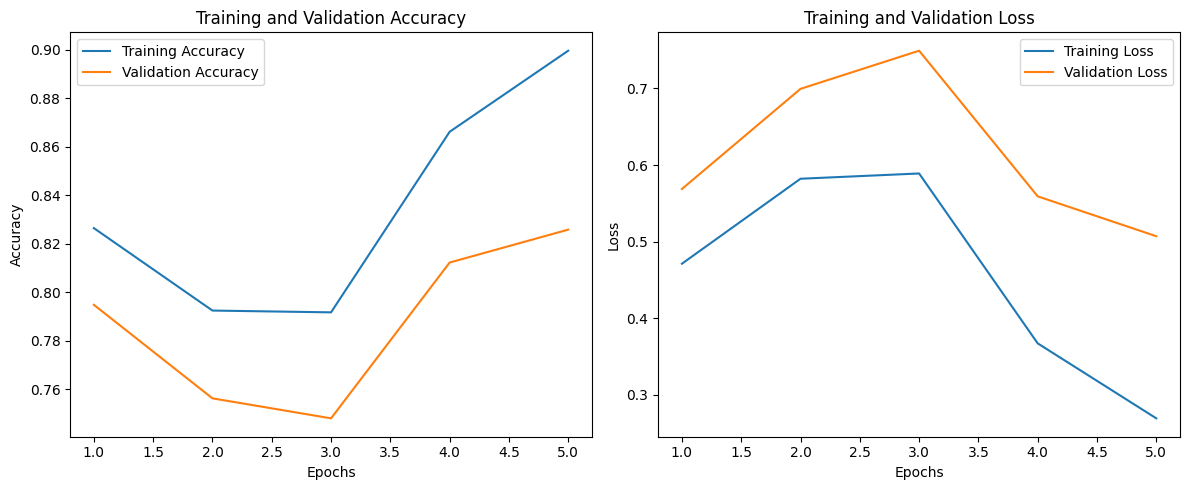

In [48]:
plot_training_history(history_0123456)

In [49]:
si.consolidate()

<h1> Task 7</h1>

In [50]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 8
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [51]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3, 4, 5, 6, 7])

In [52]:
print("\nTraining on Task with Classes 0, 1, 2, 3, 4 , 5 , 6 and 7")
history_01234567 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7]), task_num=1)



Training on Task with Classes 0, 1, 2, 3, 4 , 5 , 6 and 7
Epoch 1/5


Training Epoch 1/5: 1928batch [03:42,  8.68batch/s]                       


Training Loss: 0.9820, Training Accuracy: 0.6307
Validation Loss: 1.0023, Validation Accuracy: 0.6202
Epoch 2/5


Training Epoch 2/5: 1928batch [03:44,  8.58batch/s]                       


Training Loss: 0.8668, Training Accuracy: 0.6595
Validation Loss: 0.9023, Validation Accuracy: 0.6426
Epoch 3/5


Training Epoch 3/5: 1928batch [03:43,  8.62batch/s]                       


Training Loss: 1.1523, Training Accuracy: 0.5734
Validation Loss: 1.2198, Validation Accuracy: 0.5568
Epoch 4/5


Training Epoch 4/5: 1928batch [03:43,  8.64batch/s]                       


Training Loss: 0.8227, Training Accuracy: 0.6941
Validation Loss: 0.9026, Validation Accuracy: 0.6701
Epoch 5/5


Training Epoch 5/5: 1928batch [03:43,  8.64batch/s]                       


Training Loss: 0.6613, Training Accuracy: 0.7505
Validation Loss: 0.7632, Validation Accuracy: 0.7162
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.94      0.94      7526
     Class 1       0.96      0.90      0.93      7503
     Class 2       0.81      0.50      0.62      8366
     Class 3       0.84      0.98      0.91      8330
     Class 4       0.60      0.76      0.67      6423
     Class 5       0.78      0.51      0.61      9741
     Class 6       0.63      0.86      0.73      6304
     Class 7       0.54      0.66      0.59      7497

    accuracy                           0.75     61690
   macro avg       0.76      0.76      0.75     61690
weighted avg       0.77      0.75      0.75     61690



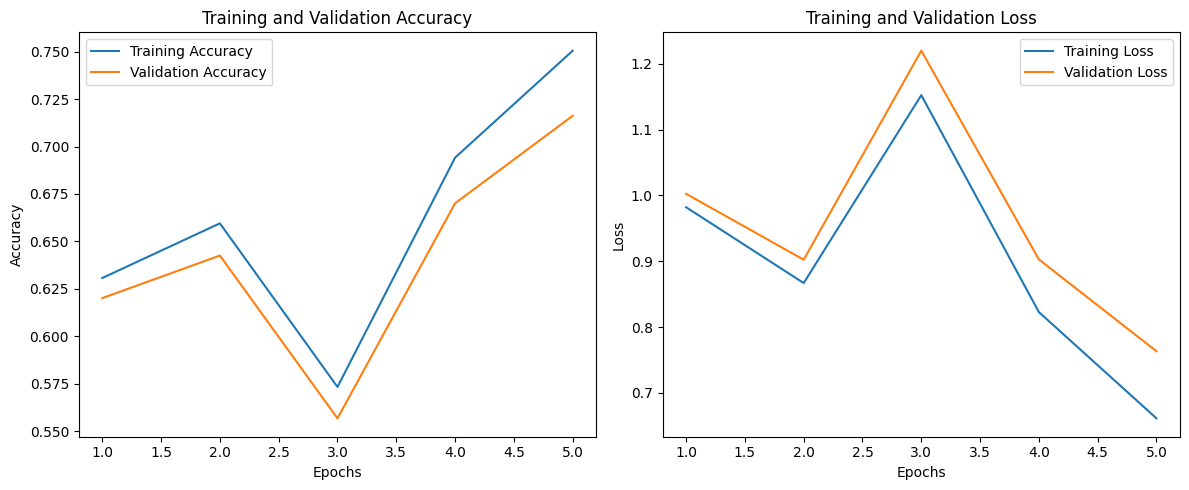

In [53]:
plot_training_history(history_01234567)

In [54]:
si.consolidate()

<h1>Task 8</h1>

In [55]:
# Extend model to handle classes 0, 1, 2, and 3
num_classes = 9
model = create_model(num_classes)
# Reinitialize SI with the updated model
si = SynapticIntelligence(model)


In [56]:
# Prepare data for classes 0, 1, 2, and 3
X_train_task, y_train_task = filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8])
X_val_task, y_val_task = filter_data(X_val, y_val, [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [57]:
print("\nTraining on Task with Classes 0, 1, 2, 3, 4 , 5 , 6 ,7 and 8")
history_012345678 = train_task_with_si(model, si, X_train_task, y_train_task, X_val_task, y_val_task, epochs=5)
evaluate(model, *filter_data(X_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8]), task_num=1)



Training on Task with Classes 0, 1, 2, 3, 4 , 5 , 6 ,7 and 8
Epoch 1/5


Training Epoch 1/5: 2250batch [04:20,  8.64batch/s]                       


Training Loss: 1.0645, Training Accuracy: 0.6056
Validation Loss: 1.0801, Validation Accuracy: 0.5989
Epoch 2/5


Training Epoch 2/5: 2250batch [04:21,  8.60batch/s]                       


Training Loss: 0.9392, Training Accuracy: 0.6573
Validation Loss: 0.9701, Validation Accuracy: 0.6446
Epoch 3/5


Training Epoch 3/5: 2250batch [04:21,  8.61batch/s]                       


Training Loss: 0.8073, Training Accuracy: 0.7057
Validation Loss: 0.8614, Validation Accuracy: 0.6861
Epoch 4/5


Training Epoch 4/5: 2250batch [04:20,  8.62batch/s]                       


Training Loss: 0.7445, Training Accuracy: 0.7292
Validation Loss: 0.8221, Validation Accuracy: 0.6957
Epoch 5/5


Training Epoch 5/5: 2250batch [04:20,  8.63batch/s]                       


Training Loss: 0.6502, Training Accuracy: 0.7637
Validation Loss: 0.7561, Validation Accuracy: 0.7177
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Task 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95      7526
     Class 1       0.96      0.92      0.94      7503
     Class 2       0.69      0.62      0.65      8366
     Class 3       0.91      0.96      0.94      8330
     Class 4       0.69      0.67      0.68      6423
     Class 5       0.59      0.76      0.67      9741
     Class 6       0.76      0.70      0.73      6304
     Class 7       0.59      0.52      0.55      7497
     Class 8       0.79      0.74      0.76     10306

    accuracy                           0.76     71996
   macro avg       0.77      0.76      0.76     71996
weighted avg       0.77      0.76      0.76     71996



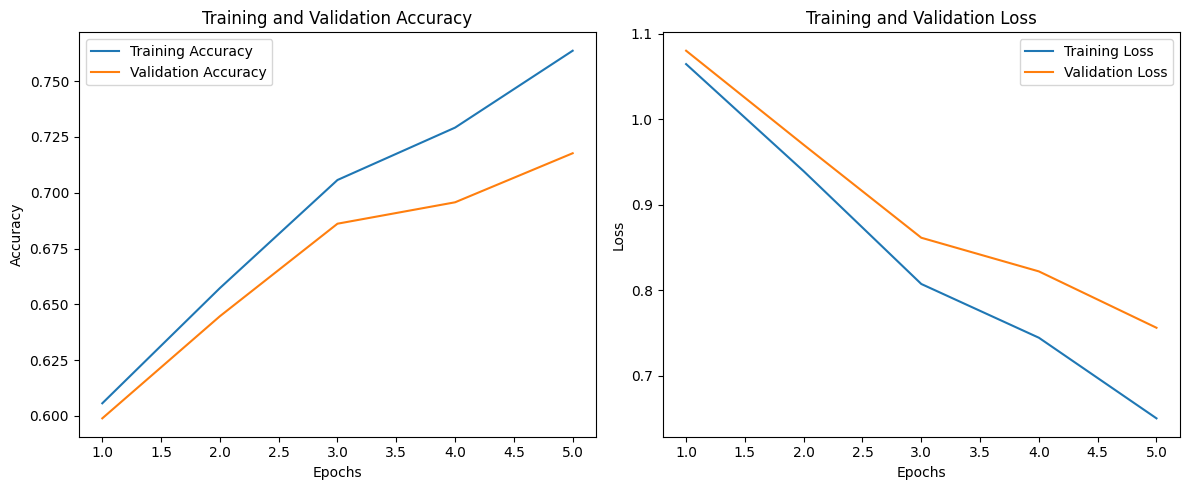

In [58]:
plot_training_history(history_012345678)

In [59]:
si.consolidate()

<h1>Performance over models</h1>

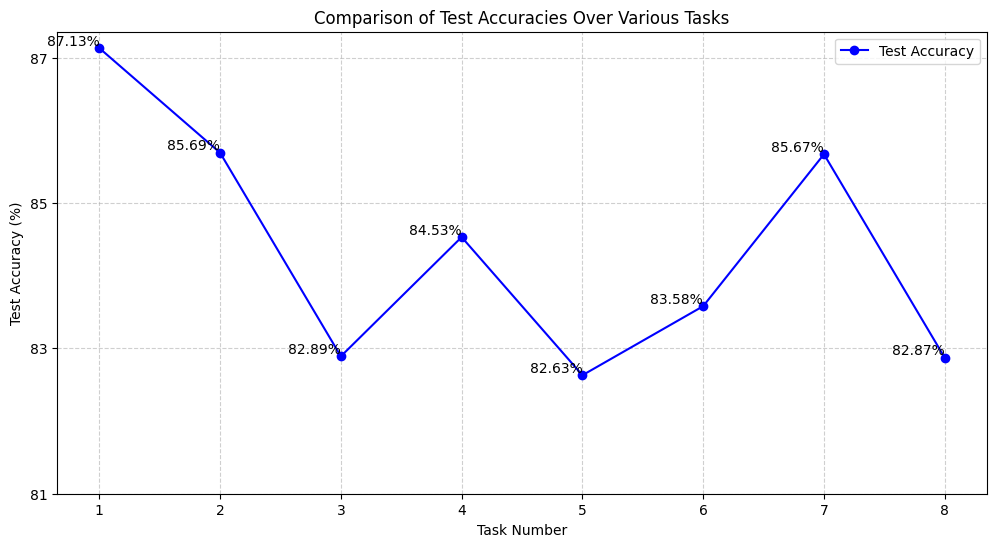

In [66]:
import matplotlib.pyplot as plt

# Sample test accuracy values (replace with your actual values)
test_accuracies = [87.13, 85.69, 82.89, 84.53, 82.63, 83.58, 85.67, 82.87]
tasks = list(range(1, 9))

plt.figure(figsize=(12, 6))
plt.plot(tasks, test_accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")

# Display values on the plot
for i, acc in enumerate(test_accuracies):
    plt.text(tasks[i], acc, f"{acc}%", fontsize=10, ha='right', va='bottom')

plt.xlabel("Task Number")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Test Accuracies Over Various Tasks")
plt.xticks(tasks)
plt.yticks(range(int(min(test_accuracies)) - 1, int(max(test_accuracies)) + 2, 2))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


<h1> Comparision</h1>

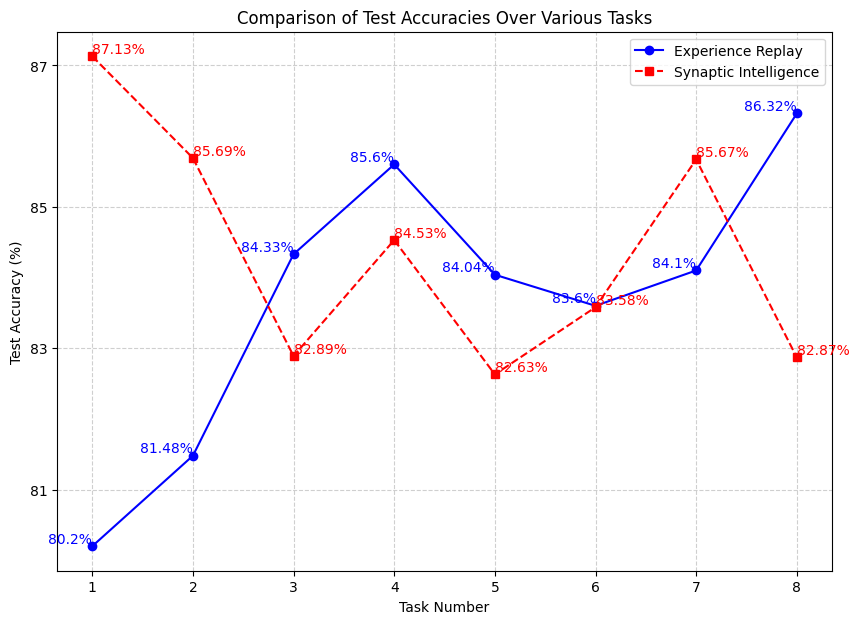

In [68]:
import matplotlib.pyplot as plt

# Sample test accuracy values (replace with actual values)
tasks = list(range(1, 9))
exp_replay = [80.2, 81.48, 84.33 , 85.6, 84.04, 83.6, 84.1, 86.32]
syn_intelligence = [87.13, 85.69, 82.89, 84.53, 82.63, 83.58, 85.67, 82.87]

plt.figure(figsize=(10, 7))
plt.plot(tasks, exp_replay, marker='o', linestyle='-', color='b', label="Experience Replay")
plt.plot(tasks, syn_intelligence, marker='s', linestyle='--', color='r', label="Synaptic Intelligence")

# Display values on the plot
for i, (exp_acc, syn_acc) in enumerate(zip(exp_replay, syn_intelligence)):
    plt.text(tasks[i], exp_acc, f"{exp_acc}%", fontsize=10, ha='right', va='bottom', color='b')
    plt.text(tasks[i], syn_acc, f"{syn_acc}%", fontsize=10, ha='left', va='bottom', color='r')

plt.xlabel("Task Number")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Test Accuracies Over Various Tasks")
plt.xticks(tasks)
plt.yticks(range(int(min(syn_intelligence)) - 1, int(max(exp_replay)) + 2, 2))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
